In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

In [4]:
from after_training_12amin import post_training as post_training_12
from after_training_3amin import post_training as post_training3
from utility import from_12to13, from_12to20, rescale_input, rescale_min_max, correct_EB, combine_to_20by20
import time
import os

In [5]:
from recompose_class import recom

# from end to end

In [6]:
maps_dir = '/pscratch/sd/j/jianyao/ForSE_plus_data/maps/'
models_dir = '/pscratch/sd/j/jianyao/ForSE_plus_data/models/'
geometry_dir = '/pscratch/sd/j/jianyao/ForSE_plus_data/geometry/'
mask_dir = '/pscratch/sd/j/jianyao/ForSE_plus_data/masks/'

In [7]:
ss_I = np.load(maps_dir+'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0, 0:348]

Ls_Q80amin = np.load(maps_dir + 'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6
Ls_U80amin = np.load(maps_dir + 'GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6

gauss_ss_ps_12 = np.load(maps_dir + 'gauss_small_scales_12_over_80_power_spectra.npy') #[2, 174, 49, 1, 25] Q, U
gauss_ss_mean_std_12 = np.load(maps_dir + 'gauss_small_scales_12_over_80_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

gauss_ss_ps_3 = np.load(maps_dir + 'gauss_small_scales_3_over_20_power_spectra_lmax_3500.npy') #[2, 174, 49, 1, 25] Q, U
gauss_ss_mean_std_3 = np.load(maps_dir + 'gauss_small_scales_3_over_20_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

ori_train_Q = np.load(maps_dir + 'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]
ori_train_U = np.load(maps_dir + 'GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]

In [24]:
maps_ren2_12Q = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_12amin_physical_units.npy')


(-0.5, 319.5, 319.5, -0.5)

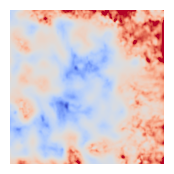

In [27]:
plt.figure(figsize = (2,2))
plt.imshow(maps_ren2_12Q[33], vmin = -30, vmax = 30)
# plt.colorbar()
plt.axis('off')

In [4]:
154*500

77000

In [5]:
256*500

128000

In [8]:
snr = 1

Generating input random noise with model SNR = 1...
12amin Generating patches...


2023-05-12 04:09:07.784425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 04:09:08.262645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38229 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-05-12 04:09:08.773332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-12 04:09:09.680634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


12amin: Renormalize patches...
Initializing...
Complete!
12amin: reproject to full sky ...
12amin: Finishing
3amin: Generating patches...
3amin: renormalize patches ...
Initializing...
Complete!
3amin: reproject to full sky ...
Time cost 5.93


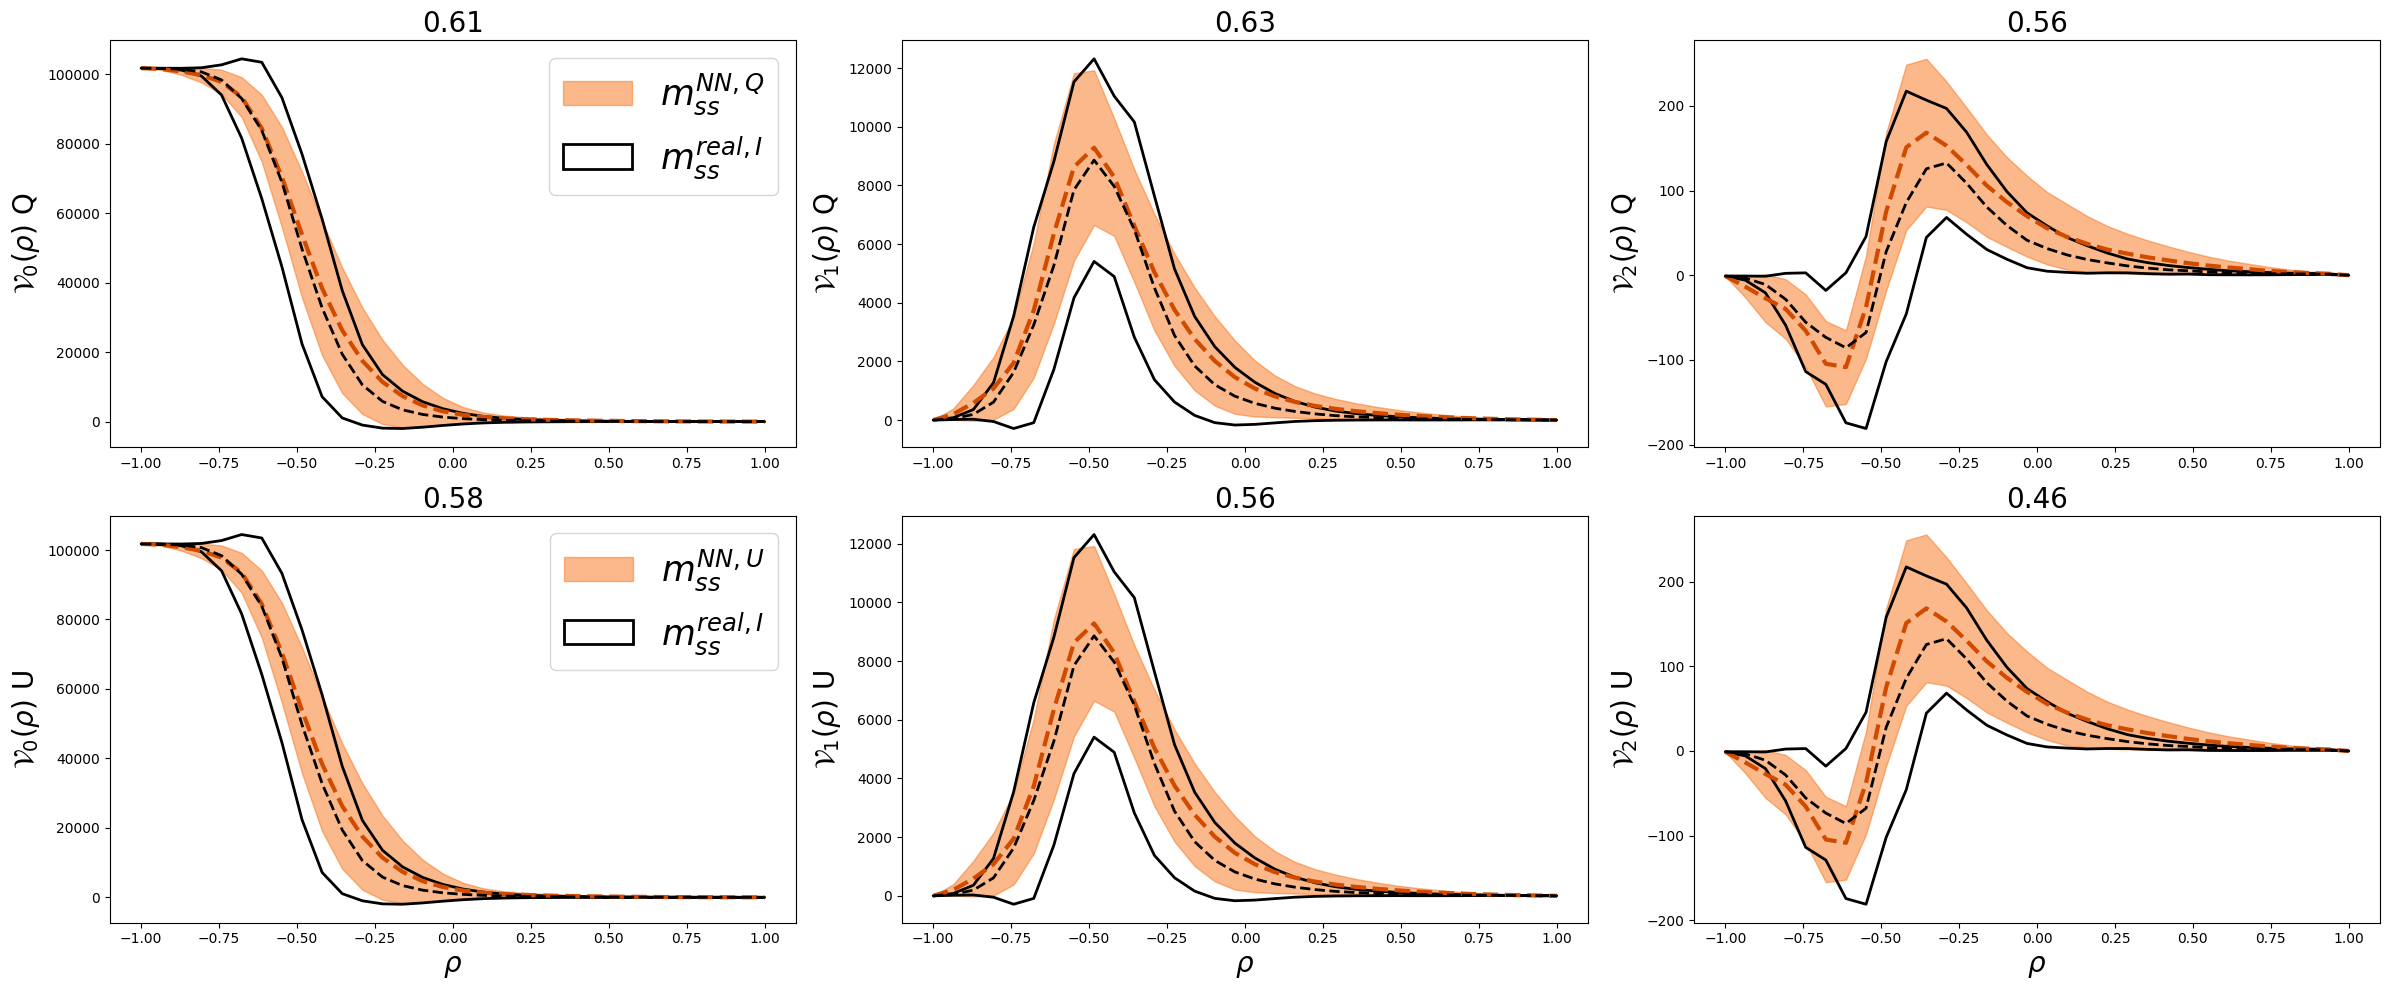

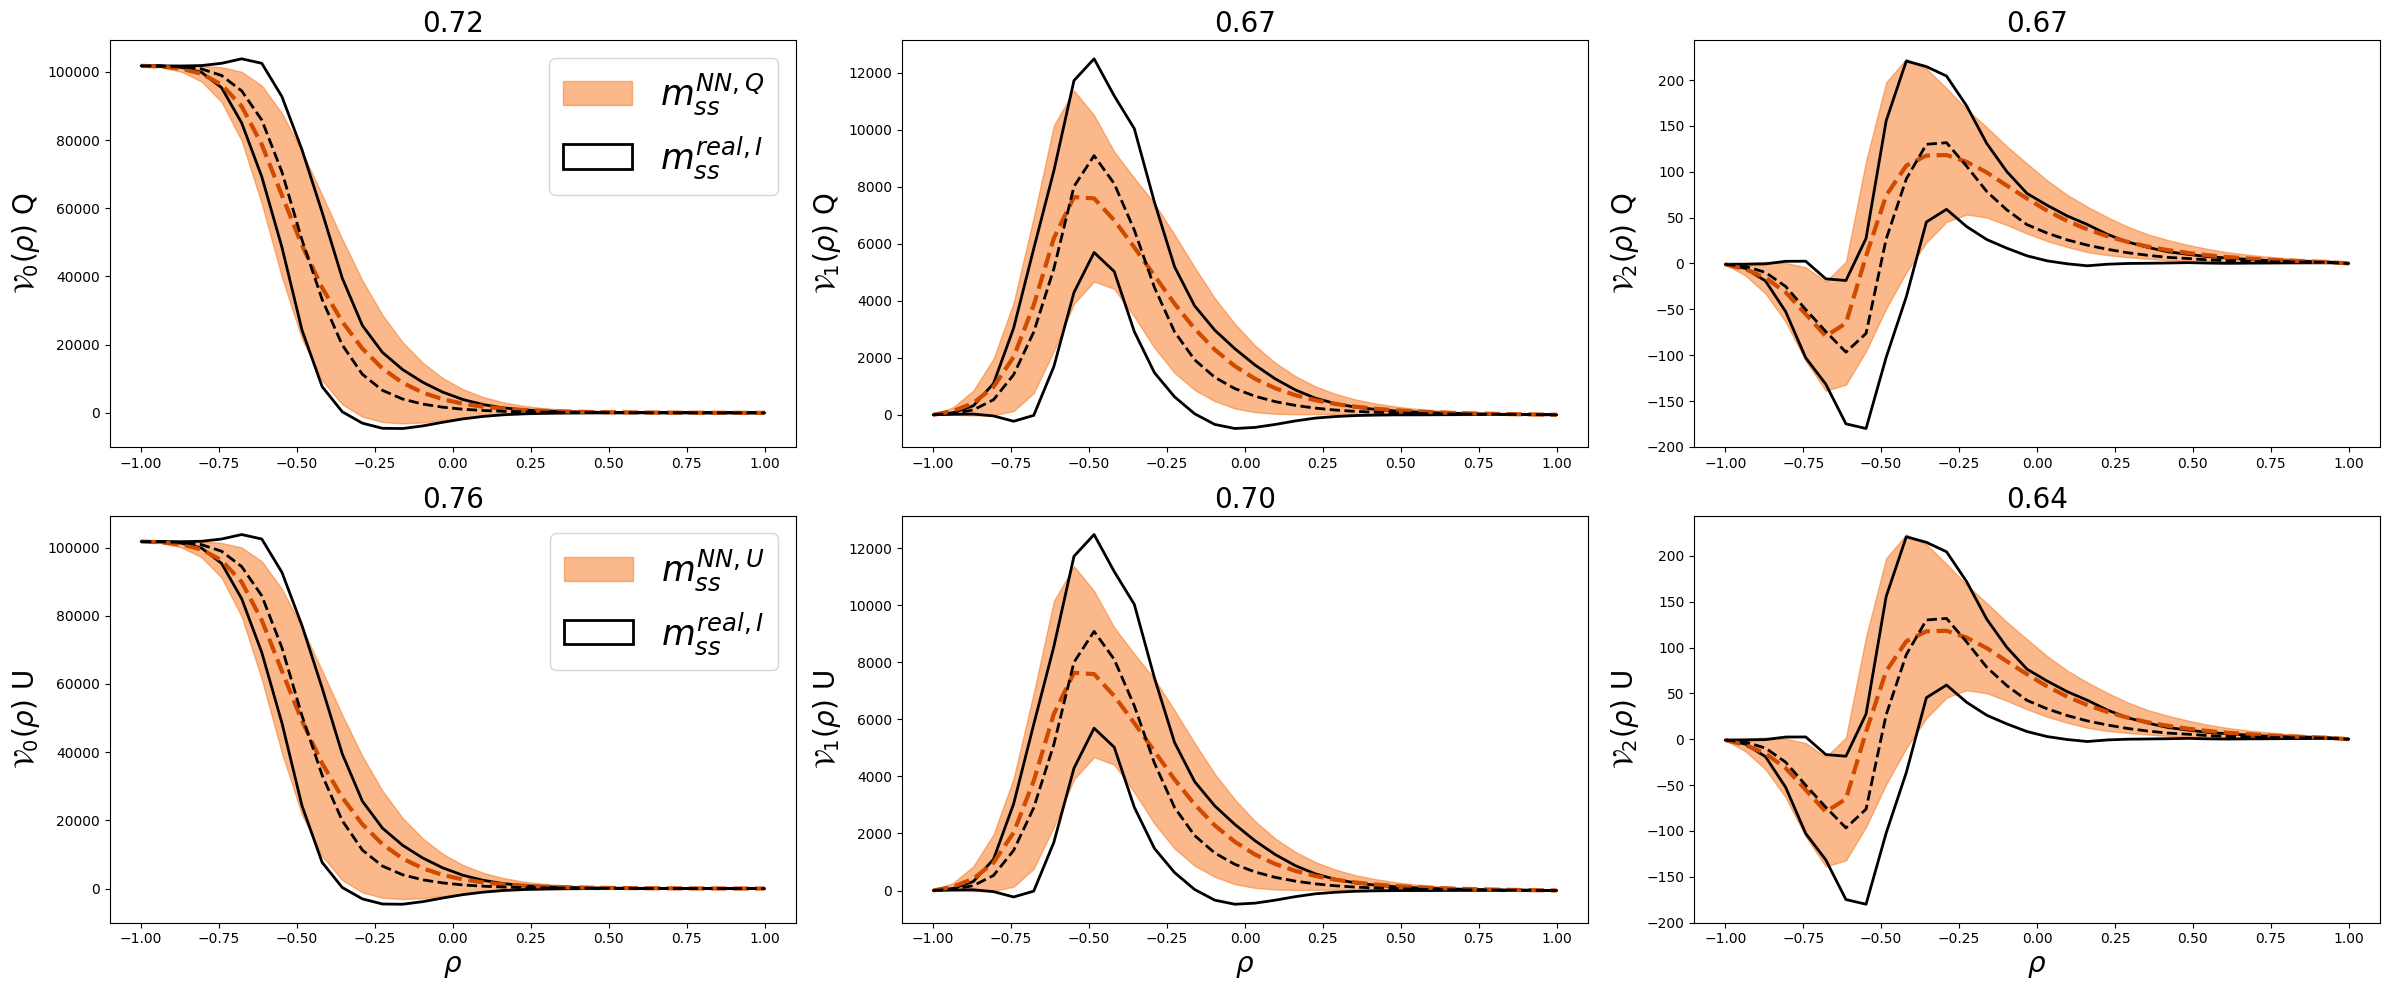

In [9]:
if snr == 10:
    ratio = 10
    model_Q_12amin = models_dir + 'model_all_h5_snr_10_Q9'
    model_U_12amin = models_dir + 'model_all_h5_snr_10_U6'
elif snr == 1:
    ratio = 1;
    model_Q_12amin = models_dir + 'model_all_h5_snr_1_Q11'
    model_U_12amin = models_dir + 'model_all_h5_snr_1_U12'
elif snr == 0.1:
    ratio = 0.1
    model_Q_12amin = models_dir + 'model_all_h5_snr_0p1_Q22'
    model_U_12amin = models_dir + 'model_all_h5_snr_0p1_U296'

start = time.time()
print('Generating input random noise with model SNR = %s...'%snr)
# np.random.seed(2048)
Ls_Q = ori_train_Q.copy()
Ls_U = ori_train_U.copy()
noise = np.random.uniform(-1, 1, (174, 320, 320))

for i in range(174):
    Ls_Q[i] = rescale_min_max(Ls_Q[i]) + noise[i]/ratio
    Ls_U[i] = rescale_min_max(Ls_U[i]) + noise[i]/ratio
    
Ls_rescaled_Q = rescale_input(Ls_Q)
Ls_rescaled_U = rescale_input(Ls_U)

# Ls_Q = np.load('/pscratch/sd/j/jianyao/forse_output/Random_training_files/Random_10_testing_data_extended/Random_10_testing_data_Nico_T12amin_Q80amin_099.npy')[1, 0:174]
# Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/Random_training_files/Random_10_testing_data_extended/Random_10_testing_data_Nico_T12amin_U80amin_099.npy')[1, 0:174]

print('12amin Generating patches...')
model_Q = tf.keras.models.load_model(model_Q_12amin)
model_U = tf.keras.models.load_model(model_Q_12amin)

NNout_Q_12 = model_Q.predict(Ls_rescaled_Q)
NNout_U_12 = model_U.predict(Ls_rescaled_U)

print('12amin: Renormalize patches...')
output12 = post_training_12(NNout_Q_12[:,:,:,0] , NNout_U_12[:,:,:,0], ss_I, Ls_Q80amin, Ls_U80amin, MF = True)
output12.normalization(gauss_ss_ps_12, gauss_ss_mean_std_12, mask_path = 'mask_320*320.npy')
output12.plot_MF()


recom_12 = recom(npix = 320, pixelsize = 3.75, overlap = 2, nside = 2048, 
                 apodization_file = '/global/homes/j/jianyao/Small_Scale_Foreground/mask_320*320.npy', 
                 xy_inds_file = '/pscratch/sd/j/jianyao/forse_recompose/recompose_xinds_yinds_2048', 
                 index_sphere_file = '/pscratch/sd/j/jianyao/forse_recompose/recompose_footprint_healpix_index_2048', verbose=False)

print('12amin: reproject to full sky ...')
full_Q_12 = recom_12.recompose_fast(output12.NNmapQ_corr)
full_U_12 = recom_12.recompose_fast(output12.NNmapU_corr) 
maps_12amin = correct_EB(full_Q_12, full_U_12)

print('12amin: Finishing')

Ls_13aminQ, Ls_13aminU = from_12to13(output12.NNmapQ_corr, output12.NNmapU_corr) # to normalize the output from 3amin

Ls_20aminQ, Ls_20aminU = from_12to20(output12.NNmapQ_corr, output12.NNmapU_corr) # to be the input for the 3amin
del output12

Ls_rescaled_Q, Ls_rescaled_U = rescale_input(Ls_20aminQ), rescale_input(Ls_20aminU)

print('3amin: Generating patches...')
model_Q_3 = tf.keras.models.load_model(models_dir + 'model_3amin_Q154')
model_U_3 = tf.keras.models.load_model(models_dir + 'model_3amin_U256')

NNout_Q = model_Q_3.predict(Ls_rescaled_Q)
NNout_U = model_U_3.predict(Ls_rescaled_U)

print('3amin: renormalize patches ...')
output3 = post_training3(NNout_Q, NNout_U, ss_I, Ls_13aminQ, Ls_13aminU, MF = True)
output3.normalization(gauss_ss_ps_3, gauss_ss_mean_std_3, mask_path = 'mask_320*320.npy')
output3.combine_to_20by20(output3.NNmapQ_corr, output3.NNmapU_corr, maps = 'ss_norm')
output3.combine_to_20by20(NNout_Q.reshape(174,49,320,320), NNout_U.reshape(174,49,320,320), maps = 'ss')
test = output3.plot_MF(patch_N = 3, savedir=False)

recom_3 = recom(npix = 1280, pixelsize = 0.9375, overlap = 2, nside = 4096, 
                 apodization_file = mask_dir + 'mask_1280*1280.npy', 
                 xy_inds_file = geometry_dir + 'recompose_xinds_yinds_4096', 
                 index_sphere_file = geometry_dir + 'recompose_footprint_healpix_index_4096', verbose=False)

print('3amin: reproject to full sky ...')
full_Q = recom_3.recompose_fast(output3.NN_20by20_Q_norm)
full_U = recom_3.recompose_fast(output3.NN_20by20_U_norm) 

maps_3amin = correct_EB(full_Q, full_U)

del output3
end = time.time()

print('Time cost %.02f minutes!'%((end - start)/60))

In [12]:
np.max(NNout_Q)

0.9999403

In [93]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [14]:
from validation_class import validate_3amin
from pathlib import Path

In [15]:
cls_pt = np.load('cls_poltens_maps_0320.npz', allow_pickle=True)
cls_full_pt = cls_pt['cls_full_pt'].item()
cls_80p_pt = cls_pt['cls_80p_pt'].item()
cls_40p_pt = cls_pt['cls_40p_pt'].item()

In [21]:
# maps_80amin = hp.read_map('/pscratch/sd/j/jianyao/COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits', field = None)[1:3]*1e6 
# poltens = hp.read_map('/pscratch/sd/j/jianyao/dust_gnilc_varres_pysm_circles_uK_RJ_lmax_6143_nside_2048.fits', field = None)/0.07748637 # from uK_RJ to uK_CMB
# poltens_3amin = pysm3.apply_smoothing_and_coord_transform(poltens, fwhm=3*u.arcmin)

In [20]:
del poltens_3amin

weights loaded from /pscratch/sd/j/jianyao/w22_2048_80_sky_lmax_4096_nbins_40.fits
weights loaded from /pscratch/sd/j/jianyao/w22_2048_40_sky_lmax_4096_nbins_40.fits
weights loaded from /pscratch/sd/j/jianyao/w22_512_bicep.fits
weights loaded from /pscratch/sd/j/jianyao/w22_512_bicep.fits
weights loaded from /pscratch/sd/j/jianyao/w22_512_bicep.fits


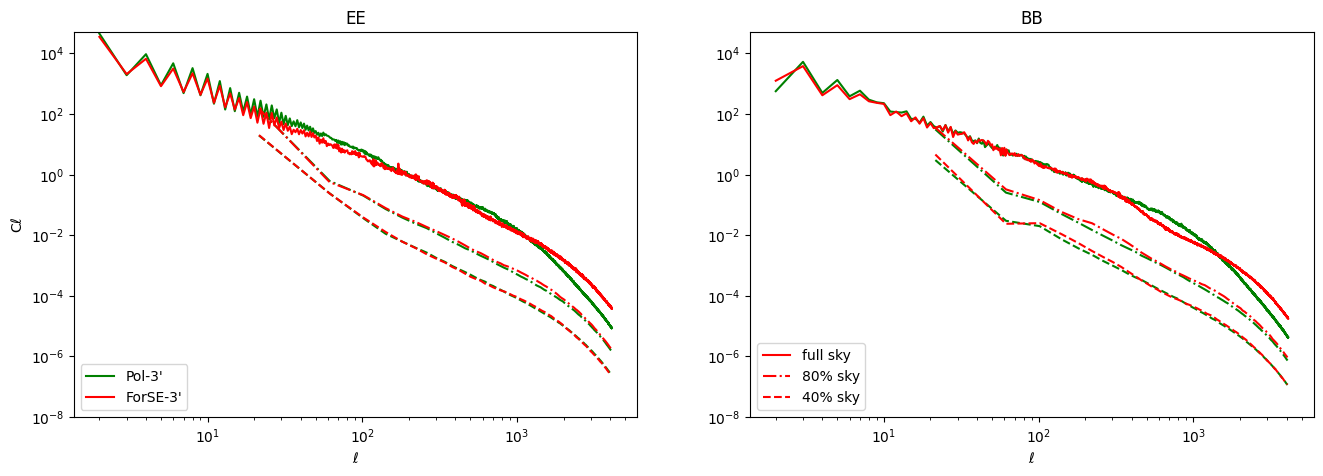

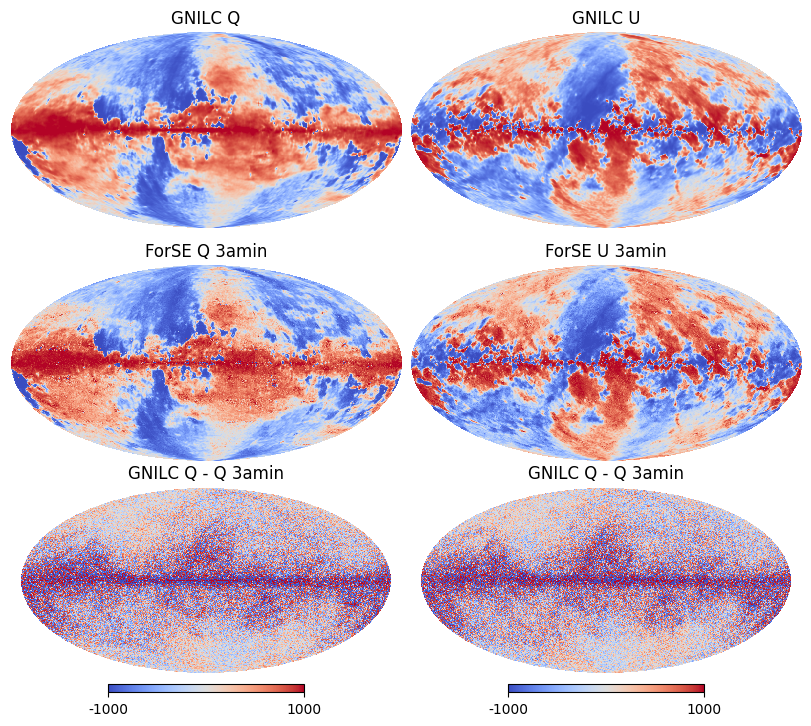

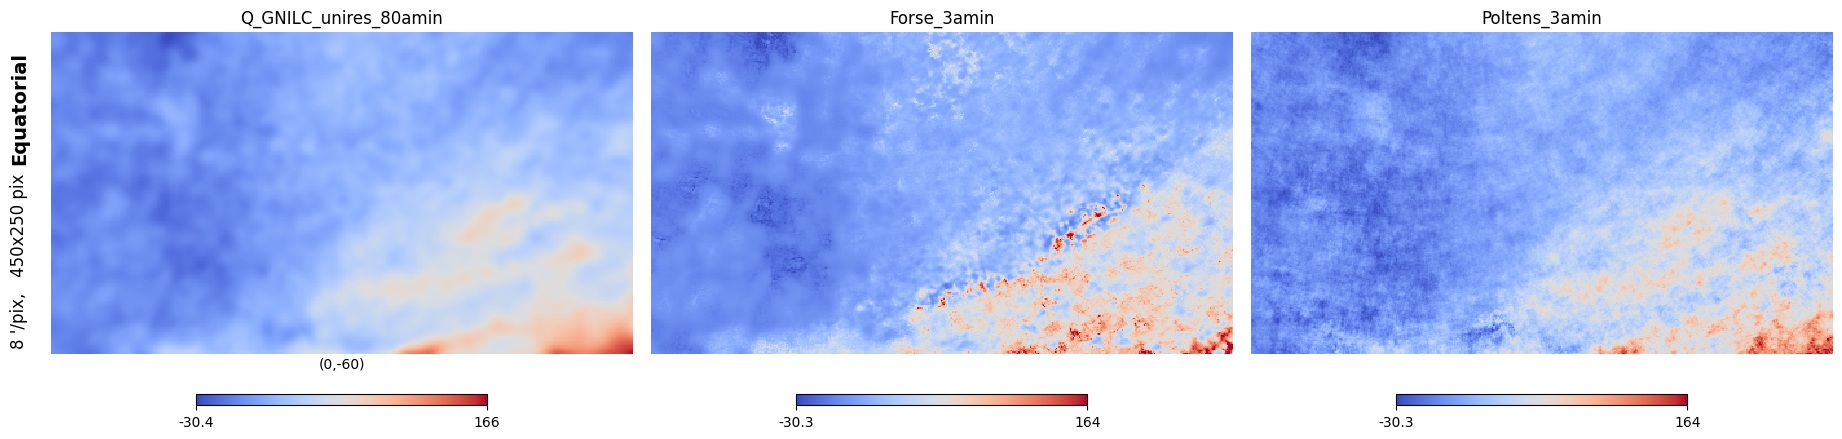

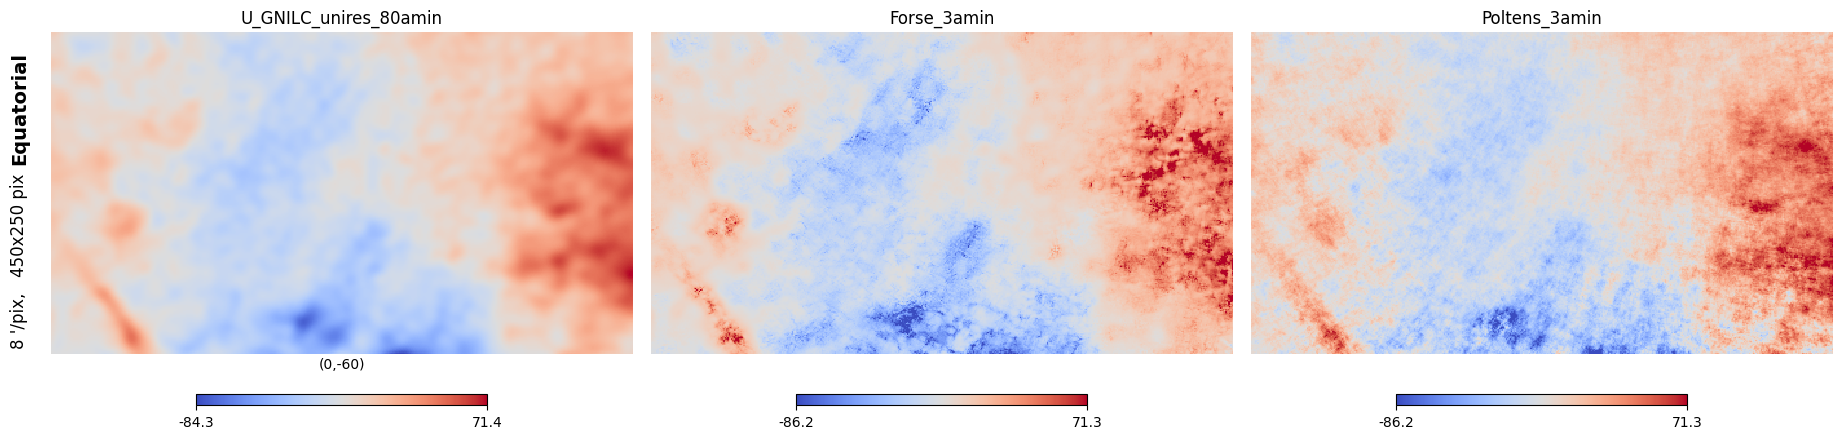

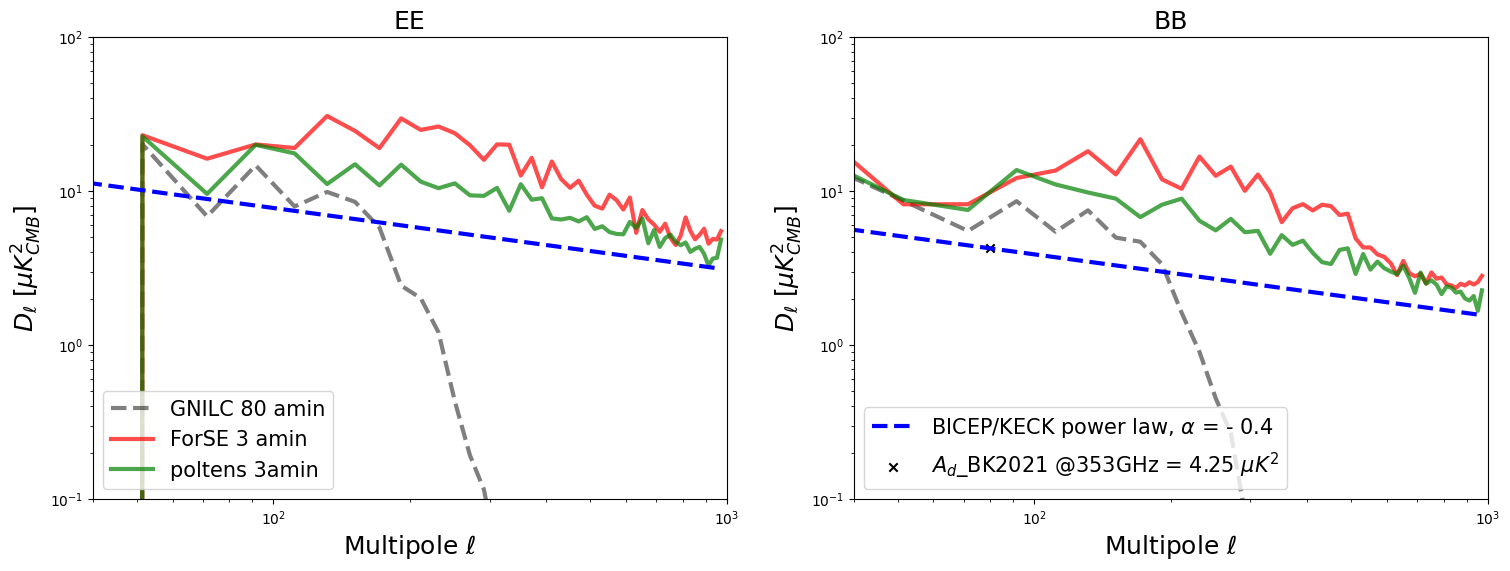

In [18]:
planck_mask = hp.read_map('/pscratch/sd/j/jianyao/HFI_Mask_GalPlane-apo2_2048_R2.00.fits', field = None)
bkmaskfile = Path('/pscratch/sd/j/jianyao/bk14_mask_gal_n0512.fits')
maskbk= hp.read_map(bkmaskfile , verbose=False)
idx = np.where((maskbk < 0) | (~np.isfinite(maskbk)))
maskbk [idx] = 0

check_3 = validate_3amin(maps_80amin, maps_3amin, poltens_3amin[1:]) # maps only contain QU 
check_3.cls_check_sky(maps_3amin, planck_mask, lmax = 4096, color = 'r', label = 'ForSE-3\'', cls_pt = [cls_full_pt, cls_80p_pt, cls_40p_pt])
check_3.show_fullsky()
check_3.show_patch()

cls_all_patches = check_3.cls_check_patch(maskbk)